In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys

import numpy as np
import pandas as pd

import scvi
from scvi.model.utils import mde

import matplotlib.pyplot as plt

import scanpy as sc


os.chdir("/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/scripts/_functions")
import importlib
import wknn

In [3]:
wknn = importlib.reload(wknn)

In [4]:
hdbca_path='/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/Braun_HDBCA_HNOCA-harmonized_2khvg.h5ad'
hnoca_path='/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/HNOCA/hnoca_pre-release_public_subset.h5ad'
query_path='/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/BRO_RA1_exp023_annotated_integrated.h5ad'

In [7]:
hdbca = sc.read_h5ad(hdbca_path)
hdbca

AnnData object with n_obs × n_vars = 1665937 × 2000
    obs: 'Age', 'CellClass', 'Chemistry', 'Region', 'Subregion', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'dissection', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'cluster_id', 'batch', 'PoolCleanOrder', 'PoolOrder', 'CellClass_Mossi', '_scvi_batch', '_scvi_labels'
    var: 'Accession', 'Chromosome', 'End', 'GeneTotalUMIs', 'Start', 'Gene', 'ensgene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'CellClass_Mossi_colors', 'Subregion_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_condition', 'hvg', 'log1p', 'title'
    obsm: 'Factors',

In [10]:
hnoca = sc.read_h5ad(hnoca_path)
hnoca

AnnData object with n_obs × n_vars = 1647038 × 3000
    obs: 'assay_sc', 'assay_differentiation', 'assay_type_differentiation', 'bio_sample', 'cell_line', 'cell_type', 'development_stage', 'disease', 'ethnicity', 'gm', 'id', 'individual', 'organ', 'organism', 'sex', 'state_exact', 'sample_source', 'source_doi', 'suspension_type_original', 'tech_sample', 'treatment', 'assay_sc_original', 'cell_line_original', 'cell_type_original', 'development_stage_original', 'disease_original', 'ethnicity_original', 'organ_original', 'organism_original', 'sex_original', 'suspension_type', 'obs_names_original', 'organoid_age_days', 'publication', 'doi', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden_pca_unintegrated_1', 'leiden_pca_unintegrated_80', 'leiden_pca_rss_1', 'leiden_pca_rss_80', 'snapseed_pca_unintegrated_level_1', 'snapseed_pca_unintegrated_level_2', 'snapseed_pca_unintegrate

In [9]:
query = sc.read_h5ad(query_path)
query

AnnData object with n_obs × n_vars = 55327 × 23409
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'singlets', 'Day', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'leiden_res_1', 'leiden_res_2', 'leiden_res_3', 'leiden_res_4', 'S_score', 'G2M_score', 'phase', 'leiden_diffmap_res_4', 'snapseed_level_1', 'snapseed_level_2', 'snapseed_level_3', 'snapseed_level_4', 'snapseed_level_5', 'leiden_res_0.5', 'hnoca_level_1', 'hnoca_level_1_score', 'hnoca_level_1_logscore', 'hnoca_level_2', 'hnoca_level_2_score', 'hnoca_level_2_logscore', 'hnoca_level_3', 'hnoca_level_3_score', 'hnoca_level_3_logscore', 'hnoca_level_4', 'hnoca_level_4_score', 'hnoca_level_4_logscore', 'hdbca

In [6]:
braun_latent = pd.read_csv("/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/assets/map_braun_latent.csv", index_col=0)
braun_latent

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
d005_AAACCAAAGCGGAGAC-1-0,-0.071874,0.502210,-0.107180,0.022779,-0.480616,0.567163,0.834300,-0.063748,-0.184513,-0.194555,-1.340649,0.493409,0.165224,-0.202079,0.162183,-0.051655,0.322010,-0.154359,-0.468034,0.262636
d005_AAACCAAAGGAGTACG-1-0,-0.069916,-0.310552,-0.106733,-0.006916,0.074643,1.429852,0.948457,-0.061524,-0.185787,-0.204151,-0.728263,1.481291,0.156232,-0.347523,0.145551,0.401646,0.734254,-0.132426,0.492510,0.258630
d005_AAACCAAAGTAATCGT-1-0,-0.090747,-1.499270,-0.140528,-0.850140,-0.054671,1.427015,1.558628,-0.081119,-0.517864,-0.211124,-1.654188,-0.132934,0.188061,0.188464,0.172775,0.714889,-0.126462,0.223936,0.580868,0.274985
d005_AAACCAAAGTTGCACA-1-0,-0.084278,0.312246,-0.096064,-0.108266,-0.260641,0.819641,0.831830,-0.050925,0.176711,-0.196017,-1.418309,1.138691,0.140799,-0.567043,0.148590,-0.025243,1.066468,0.191333,-0.319928,0.263516
d005_AAACCATTCTCACCAT-1-0,-0.059372,-1.447829,-0.133774,-0.319424,-0.224215,1.384960,1.183482,-0.071616,-0.268117,-0.199593,1.266886,-0.363040,0.160056,0.025253,0.164488,0.507828,-0.210201,-0.003571,0.832243,0.277838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10X302_7:AGAGAATAGAGGATCC-1,0.003737,1.499493,-0.073791,1.880226,-1.512838,1.074438,0.418921,-0.092213,0.424314,-0.182701,0.713424,0.163104,0.194186,-3.657937,0.173787,-3.008053,-0.779925,-2.648748,0.039933,0.283852
10X302_8:AAGCCATTCCACCTCA-1,0.011932,1.524742,-0.079646,1.459529,-1.707238,0.938641,0.757859,-0.108380,-0.819706,-0.184055,1.108455,-0.003951,0.176995,-2.524980,0.179499,-3.188459,-1.712500,-2.580979,-0.872938,0.276400
10X302_8:ACGGTTAGTTAGGCCC-1,0.006111,1.541571,-0.063155,1.260953,-1.679732,1.157527,0.518015,-0.100120,-0.648571,-0.194845,1.089915,0.194482,0.178038,-2.689340,0.173189,-3.203938,-0.707080,-2.839609,-0.787389,0.273228
10X302_8:CATGCCTCAACCCGCA-1,-0.013320,1.482393,-0.092339,1.455625,-1.343315,1.058640,0.590094,-0.107566,0.344687,-0.173668,0.699854,0.119170,0.189333,-3.171965,0.182792,-3.015223,-1.890260,-2.592529,-0.235955,0.286435


In [7]:
hnoca_latent = pd.read_csv("/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/assets/HNOCA_Braun_latent.csv", index_col=0, delimiter='\t')
hnoca_latent

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_53-0,-0.051566,0.531311,-0.094097,-0.263715,-0.247096,1.230219,0.490765,-0.055818,-0.150354,-0.194498,0.368943,0.258866,0.139487,-0.278863,0.150710,0.248077,0.716601,-0.192782,0.076494,0.256904
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_69-0,-0.049354,0.490949,-0.095231,-0.126487,0.248668,0.960756,0.226769,-0.056694,-0.063403,-0.203704,0.242741,0.049485,0.116532,-0.376648,0.133616,-0.273127,0.778610,0.352025,0.177353,0.251236
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_72-0,-0.037291,1.008882,-0.104901,0.087389,-0.010846,-0.184121,0.282094,-0.056684,-0.050505,-0.199104,-0.497747,0.056754,0.133713,-0.235147,0.150702,-0.447284,0.674000,0.423662,0.065036,0.259639
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_76-0,-0.046852,0.785692,-0.117324,-0.599148,-0.039400,1.209639,0.175247,-0.069159,-0.257637,-0.212429,-1.362987,0.690795,0.145268,-0.029908,0.159669,0.558292,0.805036,0.593037,1.060660,0.250884
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_78-0,-0.060187,0.581618,-0.119276,-0.363028,0.650376,1.370607,0.472484,-0.066552,-0.058768,-0.215816,-0.702572,0.454913,0.139041,-0.206712,0.156719,0.209966,0.678184,-0.256388,0.761335,0.255635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10X302_7:AGAGAATAGAGGATCC-1,0.003739,1.499320,-0.073770,1.880103,-1.512708,1.074469,0.419083,-0.092235,0.424379,-0.182704,0.713265,0.162654,0.194182,-3.657909,0.173781,-3.007758,-0.780098,-2.648394,0.039773,0.283852
10X302_8:AAGCCATTCCACCTCA-1,0.011928,1.524858,-0.079617,1.459532,-1.706818,0.938642,0.758019,-0.108392,-0.819311,-0.184064,1.108133,-0.004089,0.176988,-2.525255,0.179483,-3.188165,-1.712674,-2.580647,-0.873176,0.276391
10X302_8:ACGGTTAGTTAGGCCC-1,0.006113,1.541634,-0.063128,1.261041,-1.679466,1.157558,0.518148,-0.100128,-0.648824,-0.194850,1.089673,0.194232,0.178035,-2.689167,0.173203,-3.203762,-0.707513,-2.839345,-0.787751,0.273247
10X302_8:CATGCCTCAACCCGCA-1,-0.013322,1.482435,-0.092315,1.455639,-1.343102,1.058758,0.590149,-0.107577,0.344739,-0.173666,0.699629,0.119062,0.189327,-3.171867,0.182793,-3.014999,-1.890331,-2.592383,-0.236641,0.286450


Split the embeddings between Braun and PO

In [10]:
cell_names = braun_latent.index
query_cell_names = query.obs_names + "-0"
bro_idx = cell_names.isin(query_cell_names)

In [11]:
latent = braun_latent.values
latent_bro = latent[bro_idx, :]
latent_braun = latent[~bro_idx, :]

Remove MC cells from analysis

In [ ]:
## Exclude fibroblasts
mc_cells = query.obs_names[query.obs['hnoca_leiden_level_1']!="MC"] + "-0"
mc_idx = query_cell_names.isin(mc_cells)

Organize timepoints and remove early timepoint

In [ ]:
## organize the timepoints into bins
bins = [0, 30, 60, 120]
labels = ['early','mid','late']

query.obs["binned_ages"] = pd.cut(
    query.obs["Day"].astype(int), bins=bins, labels=labels
).astype('str')
print(query.obs["binned_ages"].value_counts())

binned_ages
early    39020
late      6296
mid       4900
Name: count, dtype: int64


In [19]:
cells_included = query.obs_names[(query.obs['binned_ages'].isin(['mid','late'])) & (query.obs['hnoca_leiden_level_1']!="MC")] + "-0"
cells_idx = query_cell_names.isin(cells_included)

In [ ]:
latent_bro = latent_bro[cells_idx,:]

In [23]:
query = query[cells_idx,:]

In [12]:
#### Compute WKNN ####
wknn_scanvi_q2r, adjs_scanvi_q2r = wknn.get_wknn(
    ref=latent_braun,
    query=latent_bro,
    k=100,
    query2ref=True,
    ref2query=False,
    weighting_scheme="jaccard_square",
    return_adjs=True,
)

In [13]:
meta = hdbca.obs.head()

In [14]:
hdbca.obs['CellClass'] = hdbca.obs['CellClass'].astype(str)
hdbca.obs['Subregion'] = hdbca.obs['Subregion'].astype(str)
hdbca.obs['cluster_id'] = hdbca.obs['cluster_id'].astype(str)
hdbca.obs['subregion_class'] = hdbca.obs['Subregion'].astype(str) +"_"+ hdbca.obs["CellClass"].astype(str)
hdbca.obs['subregion_class']

CellID
10X89_1:AAACGGGAGGCTACGA     Cortex_Erythrocyte
10X89_1:ACGAGGAAGAGCCTAG     Cortex_Erythrocyte
10X89_1:ACGCCAGTCGATAGAA     Cortex_Erythrocyte
10X89_1:CCGGGATCAGACACTT     Cortex_Erythrocyte
10X89_1:CGACTTCTCCCACTTG     Cortex_Erythrocyte
                                    ...        
10X302_7:AGAGAATAGAGGATCC     Midbrain_Vascular
10X302_8:AAGCCATTCCACCTCA     Midbrain_Vascular
10X302_8:ACGGTTAGTTAGGCCC     Midbrain_Vascular
10X302_8:CATGCCTCAACCCGCA     Midbrain_Vascular
10X302_8:CCTTTGGCAACGATTC     Midbrain_Vascular
Name: subregion_class, Length: 1665937, dtype: object

In [14]:
wknn_use = wknn_scanvi_q2r

scores_class = wknn.transfer_labels(hdbca, query, wknn_use, "CellClass")
scores_region = wknn.transfer_labels(hdbca, query, wknn_use, "Subregion")
scores_cluster = wknn.transfer_labels(hdbca, query, wknn_use, "cluster_id")

In [15]:
print(scores_class['best_label'].value_counts())
print("")
print(scores_region['best_label'].value_counts())

best_label
Radial glia     29891
Glioblast       10717
Fibroblast       5248
Neuroblast       4805
Neuronal IPC     1526
Neuron           1502
Oligo            1286
Neural crest      306
Placodes           44
Vascular            2
Name: count, dtype: int64

best_label
Cerebellum          17443
Midbrain             9260
Medulla              8120
Pons                 7586
Hindbrain            4206
Midbrain ventral     2433
Head                 1802
Forebrain            1590
Brain                 740
Midbrain dorsal       722
Subcortex             621
Hypothalamus          315
Cortex                304
Hippocampus           111
Thalamus               38
Striatum               36
Name: count, dtype: int64


In [17]:
query.obs['Braun_wknn_CellClass'] = scores_class['best_label']
query.obs['Braun_wknn_Subregion'] = scores_region['best_label']
query.obs['Braun_wknn_Clusters'] = scores_cluster['best_label']

In [18]:
query.obs['Braun_wknn_CellClass_score'] = np.log1p(scores_class['best_score'])
query.obs['Braun_wknn_Subregion_score'] = np.log1p(scores_region['best_score'])
query.obs['Braun_wknn_Clusters_score'] = np.log1p(scores_cluster['best_score'])

In [ ]:
#### Get braun umap ####
hdbca.obsm["X_scvi"] = latent_braun
sc.pp.neighbors(hdbca, use_rep="X_scvi", method="rapids")
sc.tl.umap(hdbca, method="rapids")
hdbca.obsm["X_umap_scvi"] = hdbca.obsm["X_umap"].copy()

[<Axes: title={'center': 'donor_id'}, xlabel='X_umap_scvi1', ylabel='X_umap_scvi2'>,
 <Axes: title={'center': 'Subregion'}, xlabel='X_umap_scvi1', ylabel='X_umap_scvi2'>,
 <Axes: title={'center': 'CellClass'}, xlabel='X_umap_scvi1', ylabel='X_umap_scvi2'>]

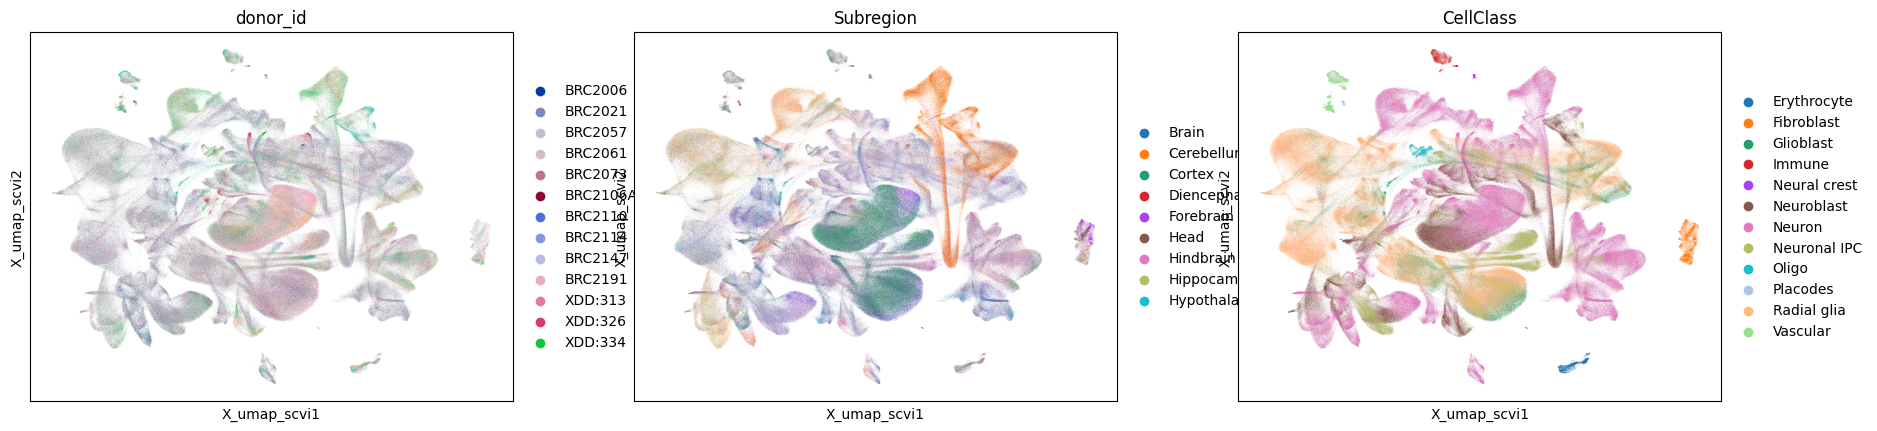

In [20]:
sc.pl.embedding(
    hdbca, basis="X_umap_scvi", color=["donor_id", "Subregion","CellClass"], show=False
)

In [20]:
trans_prob_ref = wknn.get_transition_prob_mat(hdbca.obsm["X_scvi"], k=50)

In [21]:
hdbca.obs["log_num_wknn_scanvi_q2r"] = np.log1p(
    wknn.random_walk_with_restart(
        init=np.array(wknn_scanvi_q2r.sum(axis=0)).flatten(),
        transition_prob=trans_prob_ref,
        alpha=0.1,
    )
)

In [ ]:
sc.pl.embedding(
    hdbca,     
    basis="X_umap_scvi",
    color=["log_num_wknn_scanvi_q2r","CellClass"],
    color_map="RdBu",
    vmax=np.percentile(hdbca.obs["log_num_wknn_scanvi_q2r"], 95),
    frameon=False,
    show=False,
)

In [22]:
#smooth with random walks
init = np.array(wknn_scanvi_q2r.sum(axis=0)).flatten()
wknn_scanvi_q2r_sm = wknn.random_walk_with_restart(init=init, transition_prob=trans_prob_ref, alpha=0.1)

In [23]:
# Turn to metadata
df_wknn_scanvi_q2r = pd.DataFrame(
    wknn_scanvi_q2r_sm,
    columns=['Bessler et al. 2024'],
    index=hdbca.obs_names,
)

In [24]:
df_wknn_scanvi_q2r_norm = (
    df_wknn_scanvi_q2r.apply(lambda x: np.log1p(x), axis=0)
    .apply(lambda x: np.clip(x, np.percentile(x, 1), np.percentile(x, 99)))
    .apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
)

In [25]:
df_wknn_scanvi_q2r

,Bessler et al. 2024
CellID,
10X89_1:AAACGGGAGGCTACGA,0.000015
10X89_1:ACGAGGAAGAGCCTAG,0.000010
10X89_1:ACGCCAGTCGATAGAA,0.000035
10X89_1:CCGGGATCAGACACTT,0.000009
10X89_1:CGACTTCTCCCACTTG,0.000007
...,...
10X302_7:AGAGAATAGAGGATCC,0.000781
10X302_8:AAGCCATTCCACCTCA,0.000413
10X302_8:ACGGTTAGTTAGGCCC,0.000354


In [26]:
df_wknn_scanvi_q2r_norm

,Bessler et al. 2024
CellID,
10X89_1:AAACGGGAGGCTACGA,0.000017
10X89_1:ACGAGGAAGAGCCTAG,0.000009
10X89_1:ACGCCAGTCGATAGAA,0.000046
10X89_1:CCGGGATCAGACACTT,0.000009
10X89_1:CGACTTCTCCCACTTG,0.000005
...,...
10X302_7:AGAGAATAGAGGATCC,0.001116
10X302_8:AAGCCATTCCACCTCA,0.000588
10X302_8:ACGGTTAGTTAGGCCC,0.000504


In [27]:
hdbca.obs['cov_score']=df_wknn_scanvi_q2r_norm

<Axes: title={'center': 'Coverage score'}, xlabel='X_umap_scvi1', ylabel='X_umap_scvi2'>

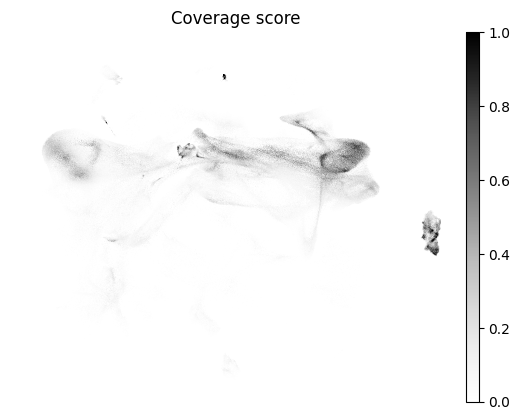

In [ ]:
sc.pl.embedding(
        hdbca,
        basis="X_umap_scvi",
        color=["cov_score"],
        title='Coverage score',
        color_map="Greys",
        vmin=0,
        vmax=1,
        show=False,
        frameon=False,
    )


In [28]:
#### Get max cov score ####
hdbca.obs["log_num_wknn_scanvi_q2r_ds_max"] = df_wknn_scanvi_q2r_norm.max(1)
# What's detected in hBO?
hdbca.obs["observed"] = (
    hdbca.obs["log_num_wknn_scanvi_q2r_ds_max"] > 0.2
).astype("category")

In [29]:
avg_cov_cl_ref = np.array(
    [
        hdbca.obs["log_num_wknn_scanvi_q2r_ds_max"][
            hdbca.obs.cluster_id == x
        ].mean()
        for x in np.sort(hdbca.obs.cluster_id.unique())
    ]
)

In [30]:
hdbca.obs['cluster_id'] = hdbca.obs['cluster_id'].astype(float)

In [31]:
hdbca.obs["is_in_cov_cl"] = np.isin(
    hdbca.obs["cluster_id"], np.where(avg_cov_cl_ref > 0.2)[0]
)
hdbca.obs["is_in_cov_cl"] = hdbca.obs["is_in_cov_cl"].astype("category")

In [32]:
plt.rcParams['figure.figsize']=(7,7)

In [35]:
hdbca.obs['presence_max'] = hdbca.obs['cov_score'].copy()
del hdbca.obs['log_num_wknn_scanvi_q2r']
del hdbca.obs['cov_score']
del hdbca.obs['log_num_wknn_scanvi_q2r_ds_max']
del hdbca.obs['observed']
del hdbca.obs['is_in_cov_cl']

In [ ]:
hdbca.write_h5ad('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/Braun_HDBCA_HNOCA-harmonized_2khvg.h5ad')

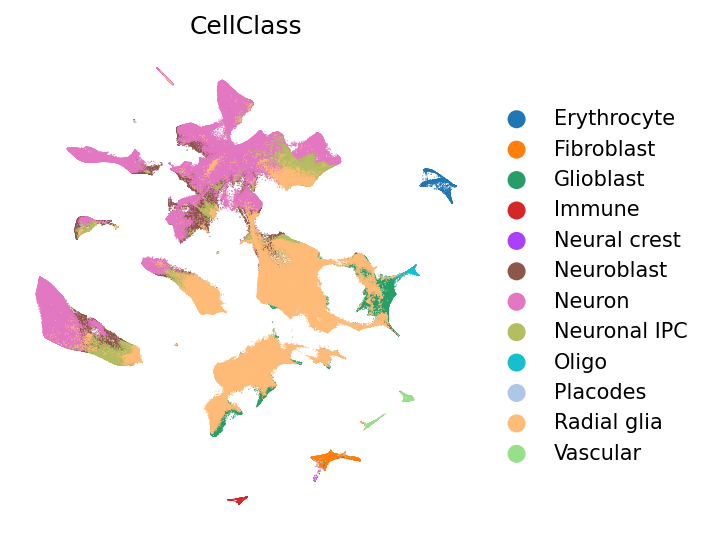

In [45]:
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (150)}):
    sc.pl.scatter(hdbca, basis="Embedding", color=["CellClass"], size=1, frameon=False, show=False)

In [43]:
hdbca.obs['CellClass_Mossi']

CellID
10X89_1:AAACGGGAGGCTACGA     Erythrocyte
10X89_1:ACGAGGAAGAGCCTAG     Erythrocyte
10X89_1:ACGCCAGTCGATAGAA     Erythrocyte
10X89_1:CCGGGATCAGACACTT     Erythrocyte
10X89_1:CGACTTCTCCCACTTG     Erythrocyte
                                ...     
10X302_7:AGAGAATAGAGGATCC       Vascular
10X302_8:AAGCCATTCCACCTCA       Vascular
10X302_8:ACGGTTAGTTAGGCCC       Vascular
10X302_8:CATGCCTCAACCCGCA       Vascular
10X302_8:CCTTTGGCAACGATTC       Vascular
Name: CellClass_Mossi, Length: 1665937, dtype: category
Categories (14, object): ['Erythrocyte', 'Failed', 'Fibroblast', 'Glioblast', ..., 'Pre-OPC', 'Pre-astrocyte', 'Radial glia', 'Vascular']

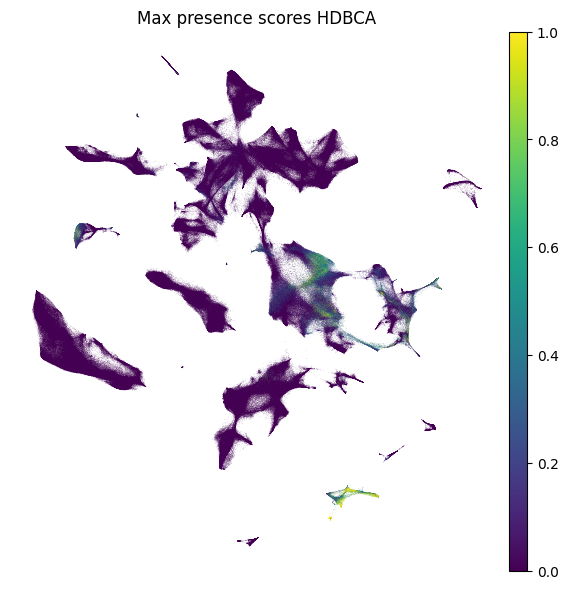

In [44]:
sc.pl.embedding(
    hdbca,
    basis="X_Embedding",
    color=["log_num_wknn_scanvi_q2r_ds_max"],
    color_map="viridis",
    title="Max presence scores HDBCA",
    frameon=False,
    size=0.2,
    sort_order=False,
    show=False,
    legend_loc='none'
)
plt.gca().collections[-1].colorbar.remove()

# Show the plot without the color scale
plt.show()

# get scores for the hnoca

In [48]:
cell_names = hnoca_latent.index
hdbca_cell_names = hdbca.obs_names + "-1"
hdbca_idx = cell_names.isin(hdbca_cell_names)

In [49]:
latent = hnoca_latent.values
latent_hnoca = latent[~hdbca_idx, :]
latent_braun = latent[hdbca_idx, :]

In [50]:
#### Compute WKNN ####
wknn_scanvi_q2r, adjs_scanvi_q2r = wknn.get_wknn(
    ref=latent_braun,
    query=latent_hnoca,
    k=100,
    query2ref=True,
    ref2query=False,
    weighting_scheme="jaccard_square",
    return_adjs=True,
)

In [51]:
hdbca.obs['CellClass'] = hdbca.obs['CellClass'].astype(str)
hdbca.obs['Subregion'] = hdbca.obs['Subregion'].astype(str)
hdbca.obs['cluster_id'] = hdbca.obs['cluster_id'].astype(str)
hdbca.obs['subregion_class'] = hdbca.obs['Subregion'].astype(str) +"_"+ hdbca.obs["CellClass"].astype(str)
hdbca.obs['subregion_class']

CellID
10X89_1:AAACGGGAGGCTACGA     Cortex_Erythrocyte
10X89_1:ACGAGGAAGAGCCTAG     Cortex_Erythrocyte
10X89_1:ACGCCAGTCGATAGAA     Cortex_Erythrocyte
10X89_1:CCGGGATCAGACACTT     Cortex_Erythrocyte
10X89_1:CGACTTCTCCCACTTG     Cortex_Erythrocyte
                                    ...        
10X302_7:AGAGAATAGAGGATCC     Midbrain_Vascular
10X302_8:AAGCCATTCCACCTCA     Midbrain_Vascular
10X302_8:ACGGTTAGTTAGGCCC     Midbrain_Vascular
10X302_8:CATGCCTCAACCCGCA     Midbrain_Vascular
10X302_8:CCTTTGGCAACGATTC     Midbrain_Vascular
Name: subregion_class, Length: 1665937, dtype: object

In [52]:
wknn_use = wknn_scanvi_q2r

scores_class = wknn.transfer_labels(hdbca, hnoca, wknn_use, "CellClass")
scores_region = wknn.transfer_labels(hdbca, hnoca, wknn_use, "Subregion")
scores_cluster = wknn.transfer_labels(hdbca, hnoca, wknn_use, "cluster_id")
scores_subregion_class = wknn.transfer_labels(hdbca, hnoca, wknn_use, "subregion_class")

In [53]:
print(scores_class['best_label'].value_counts())
print("")
print(scores_region['best_label'].value_counts())

best_label
Radial glia     567562
Neuron          506176
Neuroblast      329741
Glioblast       151120
Neuronal IPC     68034
Fibroblast       13792
Neural crest      5115
Oligo             3331
Placodes          2007
Immune              79
Vascular            75
Erythrocyte          6
Name: count, dtype: int64

best_label
Cortex              554291
Striatum            263565
Forebrain           229544
Medulla             106108
Pons                102168
Cerebellum           79643
Midbrain             74234
Subcortex            61306
Hypothalamus         61017
Thalamus             52097
Hippocampus          17860
Midbrain ventral     16575
Hindbrain            10157
Brain                 8067
Diencephalon          4389
Midbrain dorsal       2868
Head                  2819
Telencephalon          330
Name: count, dtype: int64


In [54]:
hnoca.obs['Braun_wknn_CellClass'] = scores_class['best_label']
hnoca.obs['Braun_wknn_Subregion'] = scores_region['best_label']
hnoca.obs['Braun_wknn_Clusters'] = scores_cluster['best_label']
hnoca.obs['Braun_wknn_Subregion_CellClass'] = scores_subregion_class['best_label']

In [55]:
hnoca.obs['Braun_wknn_CellClass_score'] = np.log1p(scores_class['best_score'])
hnoca.obs['Braun_wknn_Subregion_score'] = np.log1p(scores_region['best_score'])
hnoca.obs['Braun_wknn_Clusters_score'] = np.log1p(scores_cluster['best_score'])
hnoca.obs['Braun_wknn_Subregion_CellClass_score'] = np.log1p(scores_subregion_class['best_score'])

In [56]:
#### Get braun umap ####
hdbca.obsm["X_scvi"] = latent_braun
sc.pp.neighbors(hdbca, use_rep="X_scvi", method="rapids")
sc.tl.umap(hdbca, method="rapids")
hdbca.obsm["X_umap_scvi"] = hdbca.obsm["X_umap"].copy()

[<Axes: title={'center': 'donor_id'}, xlabel='X_umap_scvi1', ylabel='X_umap_scvi2'>,
 <Axes: title={'center': 'Subregion'}, xlabel='X_umap_scvi1', ylabel='X_umap_scvi2'>,
 <Axes: title={'center': 'CellClass'}, xlabel='X_umap_scvi1', ylabel='X_umap_scvi2'>]

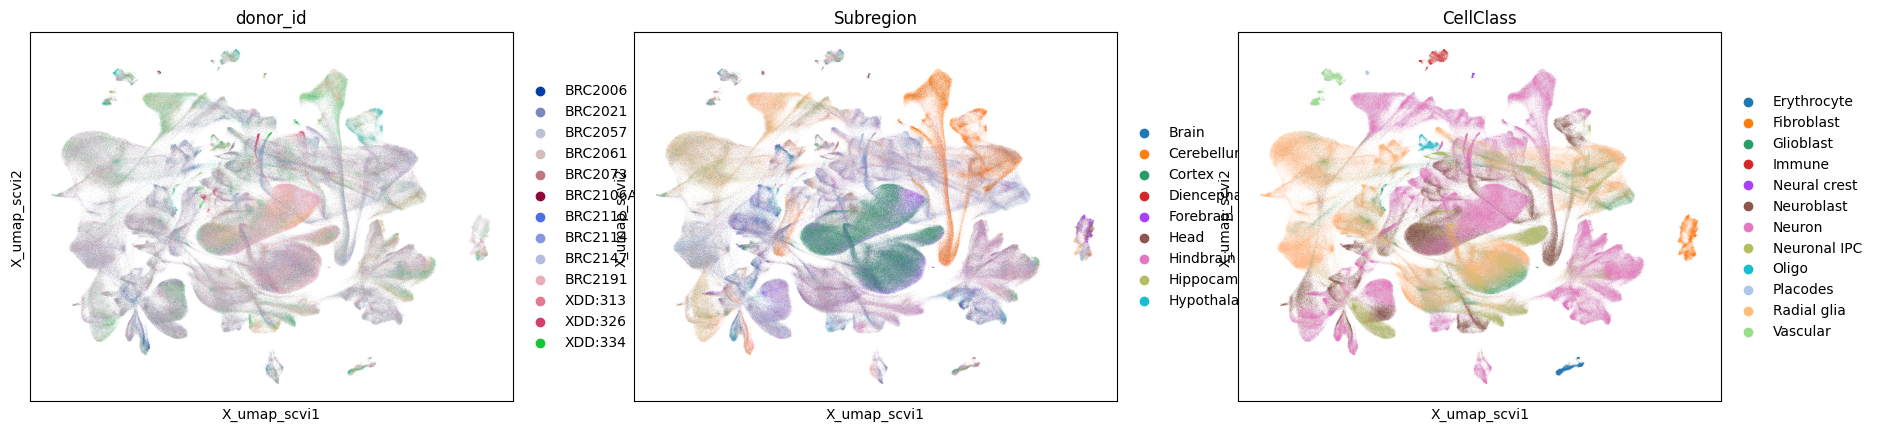

In [57]:
sc.pl.embedding(
    hdbca, basis="X_umap_scvi", color=["donor_id", "Subregion","CellClass"], show=False
)

In [58]:
trans_prob_ref = wknn.get_transition_prob_mat(hdbca.obsm["X_scvi"], k=50)

In [59]:
hdbca.obs["oa_log_num_wknn_scanvi_q2r"] = np.log1p(
    wknn.random_walk_with_restart(
        init=np.array(wknn_scanvi_q2r.sum(axis=0)).flatten(),
        transition_prob=trans_prob_ref,
        alpha=0.1,
    )
)

[<Axes: title={'center': 'oa_log_num_wknn_scanvi_q2r'}, xlabel='X_umap_scvi1', ylabel='X_umap_scvi2'>,
 <Axes: title={'center': 'CellClass'}, xlabel='X_umap_scvi1', ylabel='X_umap_scvi2'>]

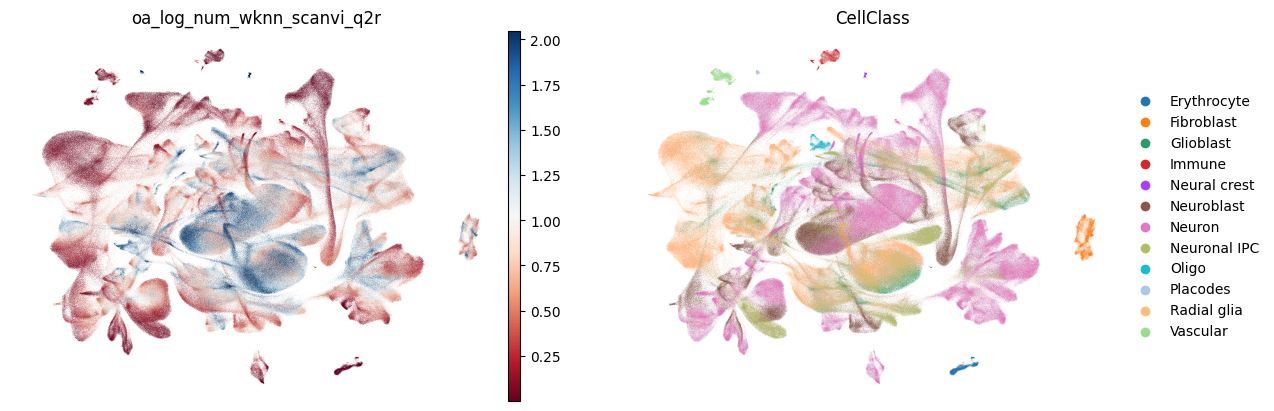

In [60]:
sc.pl.embedding(
    hdbca,     
    basis="X_umap_scvi",
    color=["oa_log_num_wknn_scanvi_q2r","CellClass"],
    color_map="RdBu",
    vmax=np.percentile(hdbca.obs["oa_log_num_wknn_scanvi_q2r"], 95),
    frameon=False,
    show=False,
)

In [61]:
#smooth with random walks
init = np.array(wknn_scanvi_q2r.sum(axis=0)).flatten()
wknn_scanvi_q2r_sm = wknn.random_walk_with_restart(init=init, transition_prob=trans_prob_ref, alpha=0.1)

In [62]:
# Turn to metadata
df_wknn_scanvi_q2r = pd.DataFrame(
    wknn_scanvi_q2r_sm,
    columns=['HNOCA'],
    index=hdbca.obs_names,
)

In [63]:
df_wknn_scanvi_q2r_norm = (
    df_wknn_scanvi_q2r.apply(lambda x: np.log1p(x), axis=0)
    .apply(lambda x: np.clip(x, np.percentile(x, 1), np.percentile(x, 99)))
    .apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
)

In [64]:
df_wknn_scanvi_q2r

,HNOCA
CellID,
10X89_1:AAACGGGAGGCTACGA,0.000289
10X89_1:ACGAGGAAGAGCCTAG,0.000218
10X89_1:ACGCCAGTCGATAGAA,0.000894
10X89_1:CCGGGATCAGACACTT,0.000237
10X89_1:CGACTTCTCCCACTTG,0.000168
...,...
10X302_7:AGAGAATAGAGGATCC,0.014069
10X302_8:AAGCCATTCCACCTCA,0.018453
10X302_8:ACGGTTAGTTAGGCCC,0.034067


In [65]:
df_wknn_scanvi_q2r_norm

,HNOCA
CellID,
10X89_1:AAACGGGAGGCTACGA,0.000000
10X89_1:ACGAGGAAGAGCCTAG,0.000000
10X89_1:ACGCCAGTCGATAGAA,0.000000
10X89_1:CCGGGATCAGACACTT,0.000000
10X89_1:CGACTTCTCCCACTTG,0.000000
...,...
10X302_7:AGAGAATAGAGGATCC,0.003589
10X302_8:AAGCCATTCCACCTCA,0.005097
10X302_8:ACGGTTAGTTAGGCCC,0.010419


In [66]:
hdbca.obs['oa_cov_score']=df_wknn_scanvi_q2r_norm

<Axes: title={'center': 'Coverage score'}, xlabel='X_umap_scvi1', ylabel='X_umap_scvi2'>

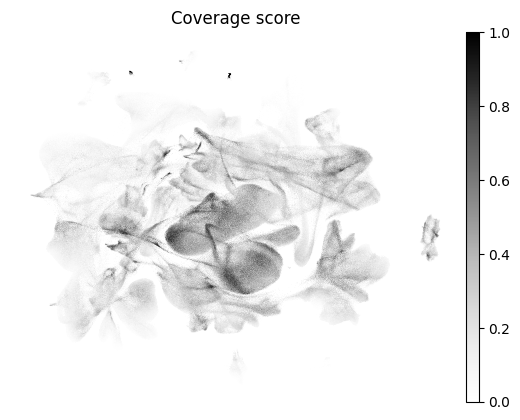

In [67]:
sc.pl.embedding(
        hdbca,
        basis="X_umap_scvi",
        color=["oa_cov_score"],
        title='Coverage score',
        color_map="Greys",
        vmin=0,
        vmax=1,
        show=False,
        frameon=False,
    )


In [68]:
#### Get max cov score ####
hdbca.obs["oa_log_num_wknn_scanvi_q2r_ds_max"] = df_wknn_scanvi_q2r_norm.max(1)
# What's detected in hBO?
hdbca.obs["observed"] = (
    hdbca.obs["oa_log_num_wknn_scanvi_q2r_ds_max"] > 0.2
).astype("category")

In [69]:
avg_cov_cl_ref = np.array(
    [
        hdbca.obs["oa_log_num_wknn_scanvi_q2r_ds_max"][
            hdbca.obs.cluster_id == x
        ].mean()
        for x in np.sort(hdbca.obs.cluster_id.unique())
    ]
)

In [70]:
hdbca.obs['cluster_id'] = hdbca.obs['cluster_id'].astype(float)

In [71]:
hdbca.obs["oa_is_in_cov_cl"] = np.isin(
    hdbca.obs["cluster_id"], np.where(avg_cov_cl_ref > 0.2)[0]
)
hdbca.obs["oa_is_in_cov_cl"] = hdbca.obs["oa_is_in_cov_cl"].astype("category")

In [73]:
hdbca.obs["max_cov_diff"] = (
    hdbca.obs["log_num_wknn_scanvi_q2r_ds_max"]
    - hdbca.obs["oa_log_num_wknn_scanvi_q2r_ds_max"]
)

In [74]:
hdbca.obs["BRO_cov_gains"] = np.clip(hdbca.obs["max_cov_diff"], 0, np.inf)


In [75]:
braun_umap = hdbca.obsm["X_umap_scvi"]
braun_umap = pd.DataFrame(braun_umap, index=hdbca.obs.index)
braun_umap.columns = ["UMAP_1", "UMAP_2"]

In [76]:
braun_emb = hdbca.obsm["X_Embedding"]
braun_emb = pd.DataFrame(braun_emb, index=hdbca.obs.index)
braun_emb.columns = ["Embedding_1", "Embedding_2"]

In [77]:
braun_meta = pd.concat([hdbca.obs, braun_umap, braun_emb], axis=1)
braun_meta.to_csv(
    "/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/scripts/03_HDBCA_mapping/03_HDBCA_mapping_data/bro_braun_meta_noMC_midlate.tsv.gz",
    sep="\t",
    index=True,
    compression="gzip",
)

In [12]:
braun_meta = pd.concat([braun_meta, braun_emb], axis=1)
braun_meta.to_csv(
    "/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/scripts/03_HDBCA_mapping/03_HDBCA_mapping_data/bro_braun_meta_noMC.tsv.gz",
    sep="\t",
    index=True,
    compression="gzip",
)

In [13]:
braun_meta

,CellID,Age,CellClass,Chemistry,Region,Subregion,organism_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,...,fraction_unspliced,cell_cycle_score,total_genes,total_UMIs,sample_id,cluster_id,Embedding_1,Embedding_2,Embedding_1,Embedding_2
0,10X89_1:AAACGGGAGGCTACGA,8.0,Erythrocyte,v2,Telencephalon,Cortex,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,...,0.351404,0.000000,121.0,4630.0,10X89_1,240.0,22.061909,11.055673,NaN,NaN
1,10X89_1:ACGAGGAAGAGCCTAG,8.0,Erythrocyte,v2,Telencephalon,Cortex,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,...,0.338333,0.000107,271.0,9334.0,10X89_1,240.0,23.594717,10.600938,NaN,NaN
2,10X89_1:ACGCCAGTCGATAGAA,8.0,Erythrocyte,v2,Telencephalon,Cortex,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,...,0.317455,0.000000,674.0,9321.0,10X89_1,236.0,25.339489,9.294833,NaN,NaN
3,10X89_1:CCGGGATCAGACACTT,8.0,Erythrocyte,v2,Telencephalon,Cortex,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,...,0.325893,0.000957,101.0,3136.0,10X89_1,240.0,22.170235,11.145865,NaN,NaN
4,10X89_1:CGACTTCTCCCACTTG,8.0,Erythrocyte,v2,Telencephalon,Cortex,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,...,0.358561,0.000000,113.0,4281.0,10X89_1,233.0,22.351114,11.133737,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10X302_7:AGAGAATAGAGGATCC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.477755,-16.342108
10X302_8:AAGCCATTCCACCTCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.562603,-16.587311
10X302_8:ACGGTTAGTTAGGCCC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.535854,-16.551435
10X302_8:CATGCCTCAACCCGCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.623299,-16.492924


In [11]:
braun_meta = pd.read_csv("/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/scripts/03_HDBCA_mapping/03_HDBCA_mapping_data/bro_braun_meta_noMC.tsv.gz", delimiter='\t')
braun_meta 

,CellID,Age,CellClass,Chemistry,Region,Subregion,organism_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,...,cell_type_ontology_term_id,fraction_mitochondrial,fraction_unspliced,cell_cycle_score,total_genes,total_UMIs,sample_id,cluster_id,Embedding_1,Embedding_2
0,10X89_1:AAACGGGAGGCTACGA,8.0,Erythrocyte,v2,Telencephalon,Cortex,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,...,CL:0000232,0.000000,0.351404,0.000000,121,4630,10X89_1,240,22.061909,11.055673
1,10X89_1:ACGAGGAAGAGCCTAG,8.0,Erythrocyte,v2,Telencephalon,Cortex,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,...,CL:0000232,0.003857,0.338333,0.000107,271,9334,10X89_1,240,23.594717,10.600938
2,10X89_1:ACGCCAGTCGATAGAA,8.0,Erythrocyte,v2,Telencephalon,Cortex,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,...,CL:0000232,0.008797,0.317455,0.000000,674,9321,10X89_1,236,25.339489,9.294833
3,10X89_1:CCGGGATCAGACACTT,8.0,Erythrocyte,v2,Telencephalon,Cortex,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,...,CL:0000232,0.001594,0.325893,0.000957,101,3136,10X89_1,240,22.170235,11.145865
4,10X89_1:CGACTTCTCCCACTTG,8.0,Erythrocyte,v2,Telencephalon,Cortex,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,...,CL:0000232,0.001869,0.358561,0.000000,113,4281,10X89_1,233,22.351114,11.133737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665932,10X302_7:AGAGAATAGAGGATCC,7.0,Vascular,v3,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,...,CL:0000000,0.029898,0.506299,0.001596,6326,23814,10X302_7,255,20.477755,-16.342108
1665933,10X302_8:AAGCCATTCCACCTCA,7.0,Vascular,v3,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,...,CL:0000000,0.059156,0.426106,0.001485,7288,39049,10X302_8,251,20.562603,-16.587310
1665934,10X302_8:ACGGTTAGTTAGGCCC,7.0,Vascular,v3,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,...,CL:0000000,0.087804,0.362151,0.001305,5815,22220,10X302_8,251,20.535854,-16.551435
1665935,10X302_8:CATGCCTCAACCCGCA,7.0,Vascular,v3,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,...,CL:0000000,0.026314,0.539421,0.002096,7217,40549,10X302_8,253,20.623299,-16.492924


In [89]:
query_umap = query.obsm["X_umap_hnoca"]
query_umap = pd.DataFrame(query_umap, index=query.obs.index)
query_umap.columns = ["UMAP_1", "UMAP_2"]

In [90]:
query_meta = pd.concat([query.obs, query_umap], axis=1)
query_meta.to_csv(
    "/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/scripts/03_HDBCA_mapping/03_HDBCA_mapping_data/bro_meta_noMC_midlate.tsv.gz",
    sep="\t",
    index=True,
    compression="gzip",
)

In [ ]:
oa_umap = hnoca.obsm["X_umap_scpoli"]
oa_umap = pd.DataFrame(oa_umap, index=hnoca.obs.index)
oa_umap.columns = ["UMAP_1", "UMAP_2"]

In [ ]:
hnoca_meta = pd.concat([hnoca.obs, oa_umap], axis=1)
hnoca_meta.to_csv(
    "/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/scripts/03_HDBCA_mapping/03_HDBCA_mapping_data/hnoca_meta.tsv.gz",
    sep="\t",
    index=True,
    compression="gzip",
)